# Psl intensity analysis — site & group comparisons
**Author:** Terence Makuvise  
**Data file:** `psl_data.csv` (columns: `subject_id`, `genotype`, `site`, `psl_intensity`)  
**Goal:** 1) One-way ANOVA per site (infection vs distant) + Tukey post-hoc.  
2) Mixed ANOVA (between = genotype, within = site) to test genotype × site interactions.  
3) Publication-style plots with significance annotations and paired-subject lines.


In [2]:
# Cell 1 — (Optional) Install packages if not present
# Run this cell only if you get import errors later. Uncomment to install.
# !pip install pandas numpy matplotlib seaborn statsmodels scipy pingouin


In [4]:
!pip install pandas numpy matplotlib seaborn statsmodels scipy pingouin

# Cell 2 — Imports & plotting settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# statsmodels imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# pingouin for mixed ANOVA (preferred)
import pingouin as pg

from matplotlib.collections import PathCollection
sns.set(style='whitegrid', context='notebook', font_scale=1.1)
plt.rcParams['figure.dpi'] = 125

# Create figures dir if not exists
if not os.path.exists('figures'):
    os.makedirs('figures')



   -------------------- ------------------- 1/2 [pingouin]
   -------------------- ------------------- 1/2 [pingouin]
   ---------------------------------------- 2/2 [pingouin]



In [6]:
# Cell 3 — Load data (adjust path if necessary)
data_path = 'psl_data.csv'   # change to 'data/psl_data.csv' if needed
df = pd.read_csv(data_path)
print("Data loaded from:", data_path)
print("Rows, cols:", df.shape)
df.head(10)


Data loaded from: psl_data.csv
Rows, cols: (24, 4)


,subject_id,genotype,site,psl_intensity
0,B0200,A,Infection,2510.262
1,B0200,A,Distant,3127.989
2,B0201,A,Infection,3251.497
3,B0201,A,Distant,2387.711
4,B0202,A,Infection,3581.017
5,B0202,A,Distant,2058.310
6,B0203,A,Infection,4559.828
7,B0203,A,Distant,3126.701
8,B0204,B,Infection,903.737
9,B0204,B,Distant,740.962


In [7]:
# Cell 4 — Basic validation & tidy-up
# Expected columns: subject_id, genotype, site, psl_intensity
expected_cols = {'subject_id','genotype','site','psl_intensity'}
present = set(df.columns.str.lower())
print("Columns in file:", df.columns.tolist())

# Normalize column names (lower-case)
df.columns = [c.strip() for c in df.columns]
# If users have upper case etc - try to standardize
colmap = {}
for c in df.columns:
    lc = c.lower()
    if lc in expected_cols:
        colmap[c] = lc
# Rename if needed
df = df.rename(columns=colmap)

# Ensure required columns present
required = ['genotype','site','psl_intensity']
if not set(required).issubset(df.columns):
    raise ValueError(f"CSV missing required columns. Must include at least {required} (subject_id optional but recommended).")

# If subject_id not present, create one (for per-sample identity)
if 'subject_id' not in df.columns:
    df['subject_id'] = np.arange(len(df)).astype(str)
    print("Warning: 'subject_id' column not provided — a synthetic id column was created (not paired).")

# Standardize text columns
df['genotype'] = df['genotype'].astype(str).str.strip()
df['site'] = df['site'].astype(str).str.strip().str.lower()  # make site lowercase for consistency
# Optionally map genotype labels if needed (user said: A->Wildtype etc.)
# If your file already uses A/B/C you can map:
# df['genotype'] = df['genotype'].map({'A':'WT','B':'DL','C':'CE'}).fillna(df['genotype'])

# Quick summary
print("\nSummary counts by genotype and site:")
print(pd.crosstab(df['genotype'], df['site']))
print("\nAny missing psl_intensity values? ", df['psl_intensity'].isnull().sum())


Columns in file: ['subject_id', 'genotype', 'site', 'psl_intensity']

Summary counts by genotype and site:
site      distant  infection
genotype                    
A               4          4
B               4          4
C               4          4

Any missing psl_intensity values?  0


In [8]:
# Cell 5 — Descriptive statistics
print("Descriptive statistics by genotype & site:")
display(df.groupby(['site','genotype'])['psl_intensity'].describe().T)


Descriptive statistics by genotype & site:


site          distant                             infection             \
genotype            A            B           C            A          B   
count        4.000000     4.000000     4.00000     4.000000    4.00000   
mean      2675.177750   915.660250  2127.23550  3475.651000  795.78275   
std        539.158056   427.495763   407.49377   850.247552   87.28288   
min       2058.310000   412.794000  1597.23800  2510.262000  691.39600   
25%       2305.360750   658.920000  1986.47150  3066.188250  759.19600   
50%       2757.206000   931.259500  2162.91550  3416.257000  793.99900   
75%       3127.023000  1187.999750  2303.67950  3825.719750  830.58575   
max       3127.989000  1387.328000  2585.87300  4559.828000  903.73700   

site                  
genotype           C  
count        4.00000  
mean      2586.17325  
std        907.37793  
min       1992.32800  
25%       2052.41650  
50%       2212.49000  
75%       2746.24675  
max       3927.38500

In [9]:
# Cell 6 — One-way ANOVAs per site + Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

anova_results = {}
tukey_results = {}

for site in sorted(df['site'].unique()):
    sub = df[df['site']==site].copy()
    # OLS model for one-way ANOVA
    model = ols('psl_intensity ~ C(genotype)', data=sub).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[site] = anova_table
    print(f"\n=== Site: {site} — One-way ANOVA ===")
    display(anova_table)
    # Tukey HSD
    try:
        tuk = pairwise_tukeyhsd(endog=sub['psl_intensity'], groups=sub['genotype'], alpha=0.05)
        tuk_df = pd.DataFrame(data=tuk.summary().data[1:], columns=tuk.summary().data[0])
        tukey_results[site] = tuk_df
        print("Tukey HSD results:")
        display(tuk_df)
    except Exception as e:
        print("Tukey test failed:", e)



=== Site: distant — One-way ANOVA ===


,sum_sq,df,F,PR(>F)
C(genotype),6.485410e+06,2.0,15.212177,0.001298
Residual,1.918486e+06,9.0,NaN,NaN


Tukey HSD results:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-1759.5175,0.0011,-2671.0230,-848.0120,True
1,A,C,-547.9423,0.2650,-1459.4478,363.5633,False
2,B,C,1211.5752,0.0121,300.0697,2123.0808,True



=== Site: infection — One-way ANOVA ===


,sum_sq,df,F,PR(>F)
C(genotype),1.490448e+07,2.0,14.387735,0.001573
Residual,4.661622e+06,9.0,NaN,NaN


Tukey HSD results:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-2679.8682,0.0013,-4100.7193,-1259.0172,True
1,A,C,-889.4778,0.2408,-2310.3288,531.3733,False
2,B,C,1790.3905,0.0162,369.5395,3211.2415,True


In [10]:
# Cell 7 — Mixed ANOVA: genotype (between) x site (within) using pingouin
# pingouin's mixed_anova requires long format with columns: dv, between, within, subject
# we will ensure site is categorical with exactly two levels (infection, distant)
print("\n=== Mixed ANOVA (between=genotype, within=site) ===")
try:
    # Ensure site is categorical
    df['site'] = df['site'].astype('category')
    # Use pingouin
    mixed = pg.mixed_anova(dv='psl_intensity', between='genotype', within='site', subject='subject_id', data=df)
    display(mixed)
    mixed_anova = mixed
except Exception as e:
    print("pingouin.mixed_anova failed or pingouin not installed. Error:", e)
    print("Attempting an alternative approach: fit Linear Mixed Model with statsmodels and report fixed effects.")
    # Alternative: MixedLM (random intercept for subject), fixed effects: genotype, site, genotype:site
    import statsmodels.formula.api as smf
    df['genotype'] = df['genotype'].astype('category')
    df['site'] = df['site'].astype('category')
    formula = 'psl_intensity ~ C(genotype)*C(site)'
    md = smf.mixedlm(formula, df, groups=df['subject_id'])
    mdf = md.fit(reml=False)
    print(mdf.summary())
    mixed_anova = None



=== Mixed ANOVA (between=genotype, within=site) ===


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,2.052408e+07,2,9,1.026204e+07,27.663096,0.000143,0.860088,NaN
1,site,8.656911e+05,1,9,8.656911e+05,2.403642,0.155465,0.210778,1.0
2,Interaction,8.658127e+05,2,9,4.329064e+05,1.201990,0.344617,0.210802,NaN


In [11]:
# Cell 8 — Pairwise comparisons for interaction: genotype pairs at each site (with p-value correction)
from statsmodels.stats.multitest import multipletests

pairwise_list = []
for site in sorted(df['site'].unique()):
    sub = df[df['site']==site]
    genotypes = sub['genotype'].unique()
    for i in range(len(genotypes)):
        for j in range(i+1, len(genotypes)):
            g1 = genotypes[i]
            g2 = genotypes[j]
            x = sub[sub['genotype']==g1]['psl_intensity'].dropna()
            y = sub[sub['genotype']==g2]['psl_intensity'].dropna()
            # If same subjects measured with both genotypes (unlikely), we'd do paired t-test; usually independent:
            tstat, p = stats.ttest_ind(x,y, equal_var=False)
            pairwise_list.append({'site':site,'g1':g1,'g2':g2,'tstat':tstat,'p_uncorrected':p})

pairwise_df = pd.DataFrame(pairwise_list)
# Multiple testing correction across all pairwise tests
pairwise_df['p_adj'] = multipletests(pairwise_df['p_uncorrected'], method='bonferroni')[1]
print("\nPairwise comparisons (genotype pairs per site) with Bonferroni-corrected p-values:")
display(pairwise_df)
# Save pairwise results
pairwise_df.to_csv('figures/pairwise_genotype_site_results.csv', index=False)
print("Saved pairwise results to figures/pairwise_genotype_site_results.csv")



Pairwise comparisons (genotype pairs per site) with Bonferroni-corrected p-values:


,site,g1,g2,tstat,p_uncorrected,p_adj
0,distant,A,B,5.114336,0.002544,0.015264
1,distant,A,C,1.621545,0.159695,0.958171
2,distant,B,C,-4.102889,0.006368,0.038207
3,infection,A,B,6.270782,0.007693,0.046159
4,infection,A,C,1.430620,0.202690,1.000000
5,infection,B,C,-3.928163,0.028400,0.170401


Saved pairwise results to figures/pairwise_genotype_site_results.csv


In [12]:
# Cell 9 — Helper: draw significance bar on axis
def add_sig_bar(ax, x1, x2, y, pval, text=None, lineheight=0.03, linewidth=1.2, fontsize=10):
    # x1, x2: x positions (numeric)
    # y: baseline y coordinate in data units
    ax.plot([x1, x1, x2, x2], [y, y+lineheight, y+lineheight, y], lw=linewidth, c='k')
    if text is None:
        if pval < 0.001:
            text = '***'
        elif pval < 0.01:
            text = '**'
        elif pval < 0.05:
            text = '*'
        else:
            text = 'ns'
    ax.text((x1+x2)/2, y+lineheight*1.2, text, ha='center', va='bottom', fontsize=fontsize)


C:\Users\makuv\AppData\Local\Temp\ipykernel_20048\3333179186.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='subject_id', columns='site', values='psl_intensity')
C:\Users\makuv\AppData\Local\Temp\ipykernel_20048\3333179186.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='subject_id', columns='site', values='psl_intensity')


Saved figure to figures/psl_by_site_boxplots.png


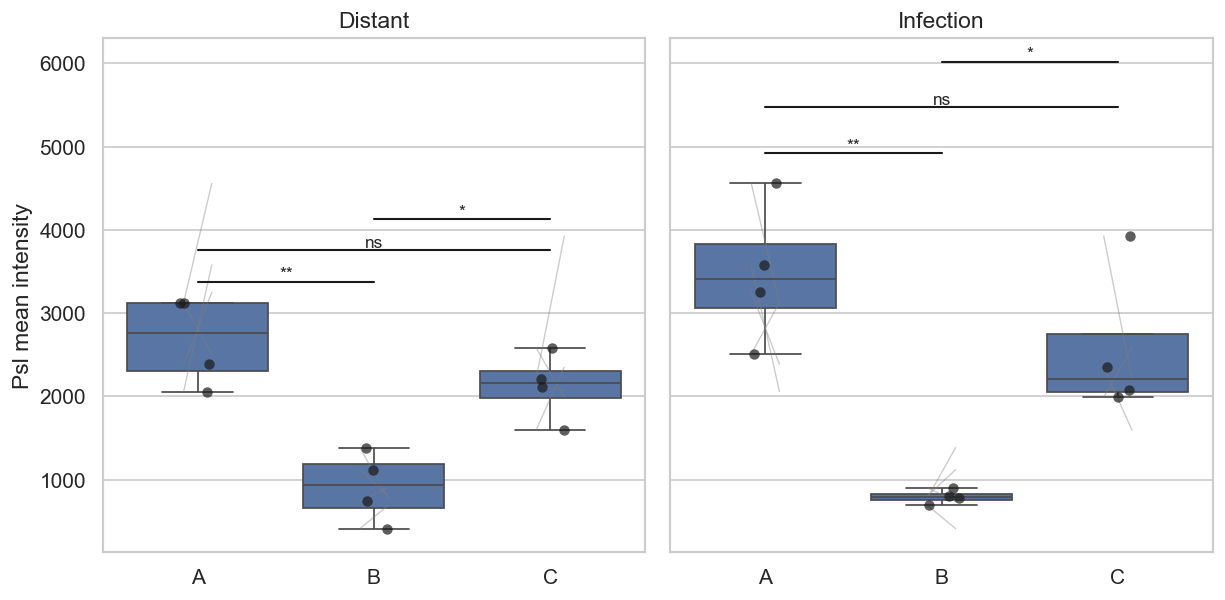

In [13]:
# Cell 10 — Plot: boxplots per site with Tukey annotations and paired subject lines
# We'll plot one column (site) per panel, ordered site_list
site_list = sorted(df['site'].unique())
n_sites = len(site_list)

fig, axes = plt.subplots(1, n_sites, figsize=(5*n_sites, 5), sharey=True)
if n_sites == 1:
    axes = [axes]

for ax, site in zip(axes, site_list):
    sub = df[df['site']==site].copy()
    order = sorted(sub['genotype'].unique())  # ensure consistent genotype ordering
    sns.boxplot(x='genotype', y='psl_intensity', data=sub, order=order, ax=ax, showfliers=False)
    sns.stripplot(x='genotype', y='psl_intensity', data=sub, order=order, ax=ax, color='k', size=6, jitter=True, alpha=0.7)
    ax.set_title(site.capitalize())
    ax.set_xlabel('')
    ax.set_ylabel('Psl mean intensity' if ax==axes[0] else '')
    # paired lines if subject has both sites
    # create wide format to see if same subject has both site measurements
    pivot = df.pivot_table(index='subject_id', columns='site', values='psl_intensity')
    # Only draw paired lines for subjects that have a value at this site and the other site(s)
    for subject in sub['subject_id'].unique():
        try:
            val = df[(df['subject_id']==subject) & (df['site']==site)]['psl_intensity'].values
            if len(val)==0:
                continue
            val = val[0]
            # find other site values for same subject (if any) and plot a faint line (this will show across panels)
            other_sites = [s for s in site_list if s!=site]
            # For each other site, if exists, plot line between genotype positions
            for o in other_sites:
                vals_o = df[(df['subject_id']==subject) & (df['site']==o)]['psl_intensity'].values
                if len(vals_o)==0:
                    continue
                # get x positions for genotypes (for this site and other site). We'll only draw short vertical jitter lines for same genotype subjects
                g_this = df[(df['subject_id']==subject) & (df['site']==site)]['genotype'].values[0]
                g_other = df[(df['subject_id']==subject) & (df['site']==o)]['genotype'].values[0]
                # if genotype same in both sites, draw a faint connecting line at x position
                if g_this == g_other and g_this in order:
                    x_pos = order.index(g_this)
                    # Slight horizontal offset to avoid overlapping central
                    ax.plot([x_pos - 0.08, x_pos + 0.08], [val, vals_o[0]], color='grey', alpha=0.4, linewidth=0.8)
        except Exception:
            continue

    # Add Tukey significance bars for this site (if results exist)
    if site in tukey_results:
        tr = tukey_results[site]
        # tr columns typically include 'group1', 'group2', 'p-adj'
        # compute y start
        ymax = sub['psl_intensity'].max()
        ystart = ymax * 1.08
        spacing = (ymax * 0.12) if ymax!=0 else 0.1
        i = 0
        for _, row in tr.iterrows():
            g1 = row['group1']; g2 = row['group2']; pval = float(row['p-adj'])
            # x positions per order
            if (g1 in order) and (g2 in order):
                x1 = order.index(g1); x2 = order.index(g2)
                add_sig_bar(ax, x1, x2, ystart + i*spacing, pval)
                i += 1

plt.tight_layout()
plt.savefig('figures/psl_by_site_boxplots.png', dpi=300, bbox_inches='tight')
print("Saved figure to figures/psl_by_site_boxplots.png")
plt.show()


C:\Users\makuv\AppData\Local\Temp\ipykernel_20048\3212488700.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=['subject_id','genotype'], columns='site', values='psl_intensity').reset_index()


Saved paired-subject plot to figures/psl_paired_subjects.png


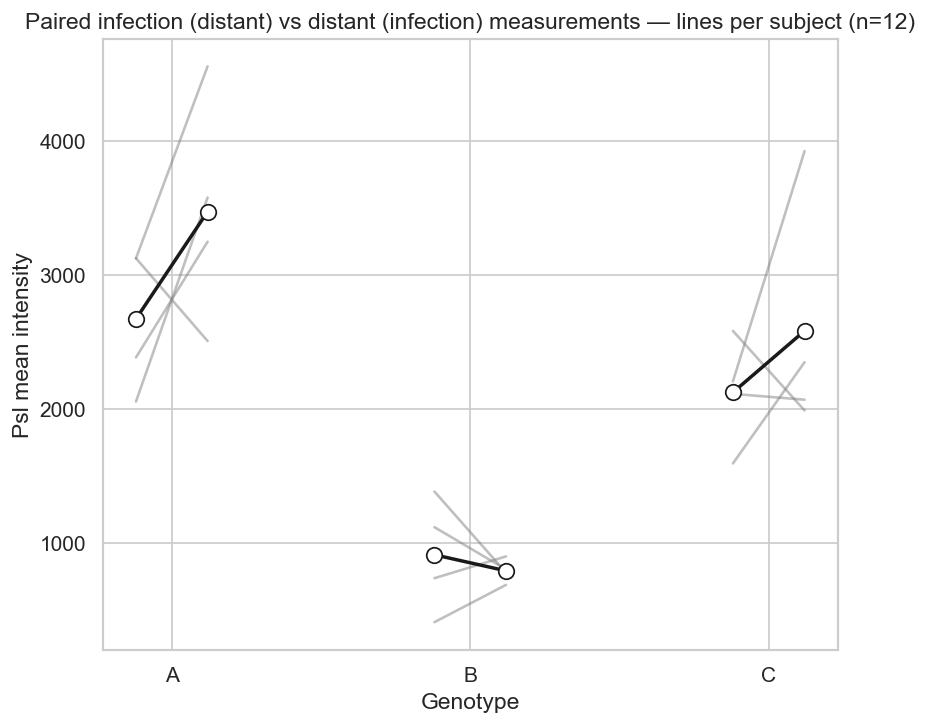

In [15]:
# Cell 11 — Paired plot showing infection vs distant for each subject (connected lines) grouped by genotype
# This plot requires the same subject measured at both sites; will still plot for those that qualify.
if len(site_list) != 2:
    print("Paired subject plot is intended for exactly two sites. Found sites:", site_list)
else:
    s1, s2 = site_list
    # Pivot to wide so we have infection and distant as columns
    wide = df.pivot_table(index=['subject_id','genotype'], columns='site', values='psl_intensity').reset_index()
    wide = wide.dropna(subset=[s1, s2])  # only subjects with both measurements
    plt.figure(figsize=(7,6))
    # jitter x positions slightly for each genotype category for visual separation
    genotypes = sorted(wide['genotype'].unique())
    x_map = {g: i for i,g in enumerate(genotypes)}
    for _, row in wide.iterrows():
        g = row['genotype']
        x = x_map[g]
        # small jitter
        x1 = x - 0.12
        x2 = x + 0.12
        plt.plot([x1, x2], [row[s1], row[s2]], color='grey', alpha=0.5)
    # plot mean points and connecting lines for genotype means
    means = wide.groupby('genotype')[[s1,s2]].mean()
    for i, g in enumerate(genotypes):
        plt.scatter(i-0.12, means.loc[g, s1], s=80, edgecolor='k', facecolor='white', zorder=5)
        plt.scatter(i+0.12, means.loc[g, s2], s=80, edgecolor='k', facecolor='white', zorder=5)
        plt.plot([i-0.12, i+0.12], [means.loc[g,s1], means.loc[g,s2]], lw=2, color='k')
    plt.xticks(range(len(genotypes)), genotypes)
    plt.xlabel('Genotype')
    plt.ylabel('Psl mean intensity')
    plt.title(f'Paired infection ({s1}) vs distant ({s2}) measurements — lines per subject (n={len(wide)})')
    plt.tight_layout()
    plt.savefig('figures/psl_paired_subjects.png', dpi=300, bbox_inches='tight')
    print("Saved paired-subject plot to figures/psl_paired_subjects.png")
    plt.show()


In [16]:
# Cell 12 — Save summary outputs (ANOVA tables and pairwise results) to CSV or text
# Save ANOVA tables (per-site) to CSV-like text
for site, table in anova_results.items():
    table.to_csv(f'figures/anova_{site}.csv')
# Save mixed ANOVA (if computed via pingouin) as CSV
if 'mixed_anova' in globals() and mixed_anova is not None:
    mixed_anova.to_csv('figures/mixed_anova_results.csv', index=False)
pairwise_df.to_csv('figures/pairwise_genotype_site_results.csv', index=False)
print("Saved per-site ANOVA, mixed ANOVA (if available) and pairwise results in the figures/ folder.")


Saved per-site ANOVA, mixed ANOVA (if available) and pairwise results in the figures/ folder.


## Interpretation notes (how to read results)
- **Per-site one-way ANOVAs**: examine `figures/anova_infection.csv` and `figures/anova_distant.csv` (if your sites are named that way) to see if genotype causes differences at each site; Tukey HSD tables show which pairs differ.  
- **Mixed ANOVA**: the `pg.mixed_anova(...)` table (if pingouin executed) tests main effects (genotype, site) and their interaction (genotype × site). A significant interaction indicates genotypes behave differently across sites.  
- **Pairwise tests**: `figures/pairwise_genotype_site_results.csv` contains pairwise t-tests with Bonferroni correction across genotype pairs at each site — useful to annotate plots or for reporting specific contrasts.

### Notes about assumptions and best practice
- ANOVA assumes approximate normality and homoscedasticity. If sample sizes are small, consider non-parametric alternatives (Kruskal–Wallis per site and Wilcoxon / Mann-Whitney for pairs).  
- For the repeated-measures design, `subject_id` must correctly pair infection and distant observations for the same subject. If `subject_id` is missing or pairing is not present, the mixed ANOVA (within-subject test) is NOT appropriate and was skipped/approximated.
